# Predição das notas de Matemática do ENEM 2016
**Por:** Diego Luiz

<img src="img/logo-enem-2016.png" />

# Importação das bibliotecas

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [86]:
# Algumas configurações do matplotlib e seaborn
%matplotlib inline

plt.rc("figure", figsize=(15, 15))

sns.set(style="dark", palette="Accent")

# Importando os dados de teste

> Nesta etapa, importamos o arquivo de testes para verificar quais são as features que estão disponíveis na nossa base de testes e possamos utilizar as mesmas na base de treino.

- **Obs. importante**: A variável target (***NU_NOTA_MT***) somente está disponível no arquivo train.csv

In [38]:
x_test = pd.read_csv("test.csv")
x_test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,...,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,...,0.0,320.0,D,H,H,C,B,A,NaN,A


In [39]:
# Algumas informações importantes do nosso DataFrame de teste
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4576 entries, 0 to 4575
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NU_INSCRICAO            4576 non-null   object 
 1   CO_UF_RESIDENCIA        4576 non-null   int64  
 2   SG_UF_RESIDENCIA        4576 non-null   object 
 3   NU_IDADE                4576 non-null   int64  
 4   TP_SEXO                 4576 non-null   object 
 5   TP_COR_RACA             4576 non-null   int64  
 6   TP_NACIONALIDADE        4576 non-null   int64  
 7   TP_ST_CONCLUSAO         4576 non-null   int64  
 8   TP_ANO_CONCLUIU         4576 non-null   int64  
 9   TP_ESCOLA               4576 non-null   int64  
 10  TP_ENSINO               1480 non-null   float64
 11  IN_TREINEIRO            4576 non-null   int64  
 12  TP_DEPENDENCIA_ADM_ESC  1480 non-null   float64
 13  IN_BAIXA_VISAO          4576 non-null   int64  
 14  IN_CEGUEIRA             4576 non-null   

> Como podemos observar, a nossa base de testes contém **4576 registros** e possui apenas **47 features** de tipos de dados variados, como object(texto, nesse caso), float e int.

In [42]:
# Verificando os missing values
nans_x_test = x_test.isna().sum()
nans_x_test

NU_INSCRICAO                 0
CO_UF_RESIDENCIA             0
SG_UF_RESIDENCIA             0
NU_IDADE                     0
TP_SEXO                      0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 3096
IN_TREINEIRO                 0
TP_DEPENDENCIA_ADM_ESC    3096
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
CO_PROVA_CN                  0
CO_PROVA_CH                  0
CO_PROVA_LC                  0
CO_PROVA_MT                  0
NU_NOTA_CN                1134
NU_NOTA_CH                1134
NU_NOTA_LC                1199
TP_LINGUA                    0
TP_STATU

In [141]:
2488 / len(nans_x_test)

52.93617021276596

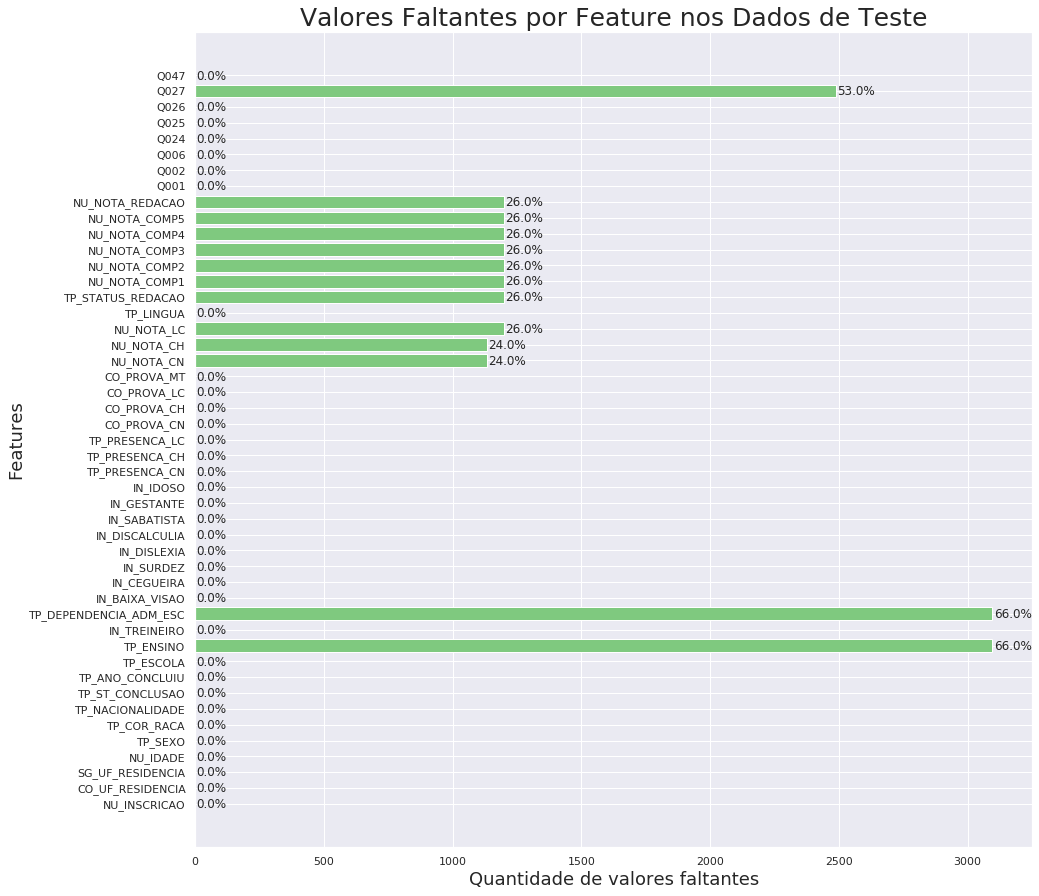

In [145]:
plt.barh(y=nans_x_test.index, width=nans_x_test.values)
for x, y in enumerate(nans_x_test):
    plt.text(y + 5, x - 0.25, "{}%".format(round(y / nans_x_test.shape[0], 0)))
plt.title("Valores Faltantes por Feature nos Dados de Teste", fontsize=25)
plt.xlabel("Quantidade de valores faltantes", fontsize=18)
plt.ylabel("Features", fontsize=18)
plt.grid(True)

> Como pode-se notar pelo gráfico acima, temos muitas features da nossa base de testes com **valores faltantes**.
Algumas chegam a ter **66%** de seus registros vazios, como é o caso das features **TP_ENSINO** e **TP_DEPENDENCIA_AD_ESC**.

In [7]:
# Eliminando os registros dos faltosos ou eliminados das provas
x_test.fillna(-1, inplace=True)

Após uma análise do dicionário de dados, inicialmente iremos exluir da análise apenas NU_INSCRIÇÂO

In [8]:
x_test = x_test.drop(columns="NU_INSCRICAO")
x_test

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,41,PR,22,F,3,1,1,5,1,-1.0,...,40.0,420.0,B,A,C,A,A,C,C,A
1,21,MA,26,F,3,1,1,8,1,-1.0,...,100.0,580.0,E,B,C,B,B,B,F,A
2,23,CE,21,M,1,1,2,0,2,3.0,...,80.0,320.0,E,E,D,B,B,A,-1,A
3,15,PA,27,F,3,1,1,8,1,-1.0,...,-1.0,-1.0,H,E,G,B,B,A,-1,A
4,41,PR,18,M,1,1,2,0,2,1.0,...,0.0,320.0,D,H,H,C,B,A,-1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,41,PR,17,F,1,1,2,0,2,1.0,...,40.0,500.0,E,E,D,A,B,A,-1,A
4572,35,SP,17,M,2,1,2,0,2,1.0,...,100.0,520.0,C,C,C,A,A,A,-1,A
4573,35,SP,19,M,1,1,1,2,1,-1.0,...,80.0,640.0,D,F,D,B,B,A,-1,D
4574,52,GO,17,M,2,2,3,0,1,-1.0,...,80.0,520.0,C,E,C,A,A,A,-1,A


In [9]:
features = x_test.columns
features

Index(['CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO',
       'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN',
       'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026',
       'Q027', 'Q047'],
      dtype='object')

In [10]:
x_test.shape

(4576, 46)

# Importando os dados de treino

In [11]:
df_train = pd.read_csv("train.csv")
df_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Columns: 167 entries, Unnamed: 0 to Q050
dtypes: float64(28), int64(79), object(60)
memory usage: 17.5+ MB


# Verificando os missing values nos dados de treino

In [13]:
df_train.isna().sum().sum()

253786

In [14]:
# Preenchendo todos os missing values com -1
df_train.fillna(-1, inplace=True)

In [15]:
df_train.isna().sum().sum()

0

# Selecionando os dados de treino em features e target

In [16]:
x_train  = df_train[features]
y_train  = df_train["NU_NOTA_MT"]

In [17]:
x_train

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,RS,24,M,1,1,1,4,1,-1.0,...,80.0,520.0,D,D,C,A,A,C,H,A
1,23,CE,17,F,3,1,2,0,2,1.0,...,80.0,580.0,A,A,B,A,A,A,-1,A
2,23,CE,21,F,3,1,3,0,1,-1.0,...,-1.0,-1.0,D,D,C,A,A,A,-1,A
3,33,RJ,25,F,0,1,1,9,1,-1.0,...,-1.0,-1.0,H,E,E,C,B,C,F,D
4,13,AM,28,M,2,1,1,4,1,-1.0,...,-1.0,-1.0,E,D,C,A,A,B,F,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,35,SP,20,M,1,1,1,3,1,-1.0,...,40.0,440.0,E,E,G,B,B,B,C,A
13726,26,PE,33,F,3,2,1,10,1,-1.0,...,80.0,560.0,A,A,C,A,B,B,I,A
13727,43,RS,15,F,1,1,3,0,1,-1.0,...,120.0,600.0,C,G,B,A,B,A,-1,A
13728,33,RJ,36,M,3,1,4,0,1,-1.0,...,100.0,460.0,B,D,G,B,B,C,E,A


In [18]:
y_train.shape

(13730,)

# Encodando as variáveis categóricas com OneHotEncoder

In [19]:
# Separando as features em catergóricas e numéricas
siglas_categoricas = ["CO", "SG", "TP", "IN", "Q0"]

cat_features = [i for i in features if i[:2] in siglas_categoricas]
num_features = x_train.columns.drop(cat_features)

In [20]:
x_train[cat_features]

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,...,TP_LINGUA,TP_STATUS_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,RS,M,1,1,1,4,1,-1.0,0,...,1,1.0,D,D,C,A,A,C,H,A
1,23,CE,F,3,1,2,0,2,1.0,0,...,1,1.0,A,A,B,A,A,A,-1,A
2,23,CE,F,3,1,3,0,1,-1.0,0,...,1,-1.0,D,D,C,A,A,A,-1,A
3,33,RJ,F,0,1,1,9,1,-1.0,0,...,0,-1.0,H,E,E,C,B,C,F,D
4,13,AM,M,2,1,1,4,1,-1.0,0,...,1,-1.0,E,D,C,A,A,B,F,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,35,SP,M,1,1,1,3,1,-1.0,0,...,0,1.0,E,E,G,B,B,B,C,A
13726,26,PE,F,3,2,1,10,1,-1.0,0,...,1,1.0,A,A,C,A,B,B,I,A
13727,43,RS,F,1,1,3,0,1,-1.0,1,...,0,1.0,C,G,B,A,B,A,-1,A
13728,33,RJ,M,3,1,4,0,1,-1.0,0,...,1,1.0,B,D,G,B,B,C,E,A


In [21]:
# Encodando variáveis categóricas como onehotencode
x_train_cat = x_train[cat_features].astype(str)

ohe = OneHotEncoder(sparse=False, handle_unknown="ignore", dtype=np.int)
ohe.fit(x_train_cat)
x_train_encoded = ohe.transform(x_train_cat)

In [22]:
# Criando dataframe com as features categóricas encodadas
cat_features_encoded = pd.DataFrame(x_train_encoded, columns=ohe.get_feature_names(cat_features))
cat_features_encoded

,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,...,Q027_I,Q027_J,Q027_K,Q027_L,Q027_M,Q047_A,Q047_B,Q047_C,Q047_D,Q047_E
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13726,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
13727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
# Aplicando o transform nos dados de teste
x_test_encoded = ohe.transform(x_test[cat_features].astype(str))

In [24]:
x_test_encoded = pd.DataFrame(x_test_encoded, columns=ohe.get_feature_names(x_test[cat_features].columns))

In [25]:
x_test_encoded

,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,...,Q027_I,Q027_J,Q027_K,Q027_L,Q027_M,Q047_A,Q047_B,Q047_C,Q047_D,Q047_E
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [26]:
x_test = pd.concat([x_test_encoded, x_test[num_features]], axis=1)
x_test

,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,...,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
0,0,0,0,0,0,0,0,0,0,0,...,22,464.8,443.5,431.8,120.0,80.0,80.0,100.0,40.0,420.0
1,0,0,0,0,0,0,0,1,0,0,...,26,391.1,491.1,548.0,120.0,120.0,120.0,120.0,100.0,580.0
2,0,0,0,0,0,0,0,0,0,1,...,21,595.9,622.7,613.6,80.0,40.0,40.0,80.0,80.0,320.0
3,0,0,0,0,1,0,0,0,0,0,...,27,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,18,592.9,492.6,571.4,100.0,80.0,60.0,80.0,0.0,320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,0,0,0,0,0,0,0,0,0,0,...,17,398.3,558.2,511.6,120.0,120.0,120.0,100.0,40.0,500.0
4572,0,0,0,0,0,0,0,0,0,0,...,17,427.6,579.7,471.1,100.0,100.0,100.0,120.0,100.0,520.0
4573,0,0,0,0,0,0,0,0,0,0,...,19,639.2,643.8,604.9,160.0,140.0,120.0,140.0,80.0,640.0
4574,0,0,0,0,0,0,0,0,0,0,...,17,427.1,467.9,540.2,140.0,80.0,80.0,140.0,80.0,520.0


In [27]:
# Montando o datafram de treino final. Cocatenando o dataframe das features categoricas com as numericas
x_train = pd.concat([cat_features_encoded, x_train[num_features]], axis=1)
x_train

,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,...,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
0,0,0,0,0,0,0,0,0,0,0,...,24,436.3,495.4,581.2,120.0,120.0,120.0,80.0,80.0,520.0
1,0,0,0,0,0,0,0,0,0,1,...,17,474.5,544.1,599.0,140.0,120.0,120.0,120.0,80.0,580.0
2,0,0,0,0,0,0,0,0,0,1,...,21,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,25,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,0,1,0,0,0,0,0,0,0,...,28,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,0,0,0,0,0,0,0,0,0,0,...,20,438.2,419.7,394.5,120.0,120.0,80.0,80.0,40.0,440.0
13726,0,0,0,0,0,0,0,0,0,0,...,33,423.8,557.9,533.0,120.0,120.0,120.0,120.0,80.0,560.0
13727,0,0,0,0,0,0,0,0,0,0,...,15,460.5,528.9,569.3,120.0,120.0,120.0,120.0,120.0,600.0
13728,0,0,0,0,0,0,0,0,0,0,...,36,422.5,621.7,569.0,100.0,100.0,80.0,80.0,100.0,460.0


# Criando e treinando o modelo
## Decision Tree

In [28]:
clf_dt = DecisionTreeRegressor()
clf_dt.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [29]:
predict_dt = clf_dt.predict(x_test)
predict_dt = pd.Series(predict_dt , name="NU_NOTA_MT")
predict_dt

0       408.7
1       410.7
2       504.3
3        -1.0
4       702.5
        ...  
4571    447.1
4572    474.0
4573    528.2
4574    518.0
4575     -1.0
Name: NU_NOTA_MT, Length: 4576, dtype: float64

# Criando arquivo para submeter o teste

In [30]:
df = pd.read_csv("test.csv")[["NU_INSCRICAO"]]
answer = pd.concat([df, predict_dt], axis=1)
answer

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,408.7
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,410.7
2,b38a03232f43b11c9d0788abaf060f7366053b6d,504.3
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,-1.0
4,715494628a50142ce8cb17191cfe6d0f3cae0934,702.5
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,447.1
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,474.0
4573,655fa6306720ff16e825903b5422a46608a77545,528.2
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,518.0


In [31]:
# Score da Decision tree = 91.5

In [32]:
answer.to_csv("answer.csv", index=False)

In [33]:
# Treinando uma Random Forest
clf_rf = RandomForestRegressor()
clf_rf.fit(x_train, y_train)

predict_rf = clf_rf.predict(x_test)
predict_rf = pd.Series(predict_rf , name="NU_NOTA_MT")

df = pd.read_csv("test.csv")[["NU_INSCRICAO"]]
answer = pd.concat([df, predict_rf], axis=1)
answer

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,422.479
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,442.602
2,b38a03232f43b11c9d0788abaf060f7366053b6d,582.057
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,-1.000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,555.896
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,458.606
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,475.460
4573,655fa6306720ff16e825903b5422a46608a77545,676.017
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,460.236


In [34]:
answer.to_csv("answer.csv", index=False)

In [35]:
# Score random forest = 93.7075